# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
import plotly
import plotly.express as px
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None) 
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)
import plotly.io as pio
pio.renderers.default = "notebook_connected"

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

**Примечание.** Для загрузки в локальный репозиторий воспользуйтесь командой: gdown 'https://drive.google.com/uc?id=1Fc0XeSyiweBTqOUuLZ-cz1XxjD3tV8Of'

In [2]:
df_zip = pd.read_csv('bank_fin.zip', sep = ';')
df = df_zip.copy()
df.head()

age         job  marital  education default       balance housing loan  \
0   59      admin.  married  secondary      no   2 343,00 $      yes   no   
1   56      admin.  married  secondary      no      45,00 $       no   no   
2   41  technician  married  secondary      no   1 270,00 $      yes   no   
3   55    services  married  secondary      no   2 476,00 $      yes   no   
4   54      admin.  married   tertiary      no     184,00 $       no   no   

   contact  day month  duration  campaign  pdays  previous poutcome deposit  
0  unknown    5   may      1042         1     -1         0  unknown     yes  
1  unknown    5   may      1467         1     -1         0  unknown     yes  
2  unknown    5   may      1389         1     -1         0  unknown     yes  
3  unknown    5   may       579         1     -1         0  unknown     yes  
4  unknown    5   may       673         2     -1         0  unknown     yes

Предоставлены данные о последней маркетинговой кампании, которую проводил банк: задачей было привлечь клиентов для открытия депозита. Необходимо проанализировать эти данные, выявить закономерность и найти решающие факторы, повлиявшие на то, что клиент вложил деньги именно в этот банк. Если вы сможете это сделать, то поднимете доходы банка и поможете понять целевую аудиторию, которую необходимо привлекать путём рекламы и различных предложений.

**Данные о клиентах банка:**

- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

**Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:**

- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).

**Прочие признаки:**

- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).

И, разумеется, наша целевая переменная **deposit**, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [3]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


Данные имею 11162 строк и 16 признаков, в balance имеется 25 пропусков

### Задание 2

In [4]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

In [5]:
# для быстрого знакомства с набором данных и получение по ним описательных статистик можно воспользоваться библиотекой dtale
""" import dtale
d = dtale.show(df)
d """

' import dtale\nd = dtale.show(df)\nd '

In [6]:
df.describe()

age           day      duration      campaign         pdays  \
count  11162.000000  11162.000000  11162.000000  11162.000000  11162.000000   
mean      41.231948     15.658036    371.993818      2.508421     51.330407   
std       11.913369      8.420740    347.128386      2.722077    108.758282   
min       18.000000      1.000000      2.000000      1.000000     -1.000000   
25%       32.000000      8.000000    138.000000      1.000000     -1.000000   
50%       39.000000     15.000000    255.000000      2.000000     -1.000000   
75%       49.000000     22.000000    496.000000      3.000000     20.750000   
max       95.000000     31.000000   3881.000000     63.000000    854.000000   

           previous  
count  11162.000000  
mean       0.832557  
std        2.292007  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        1.000000  
max       58.000000

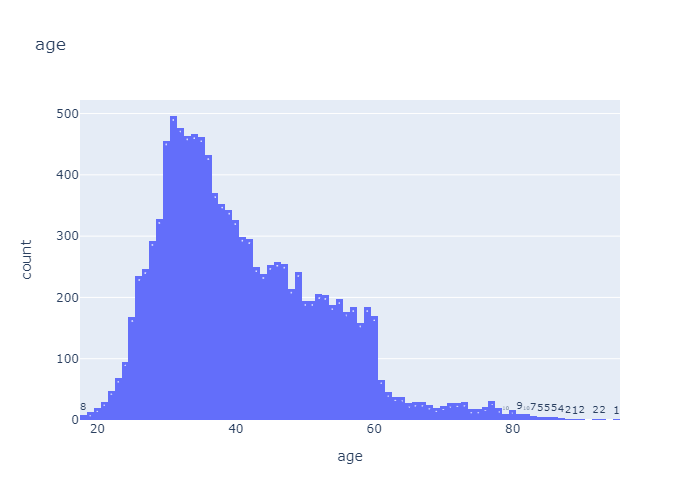

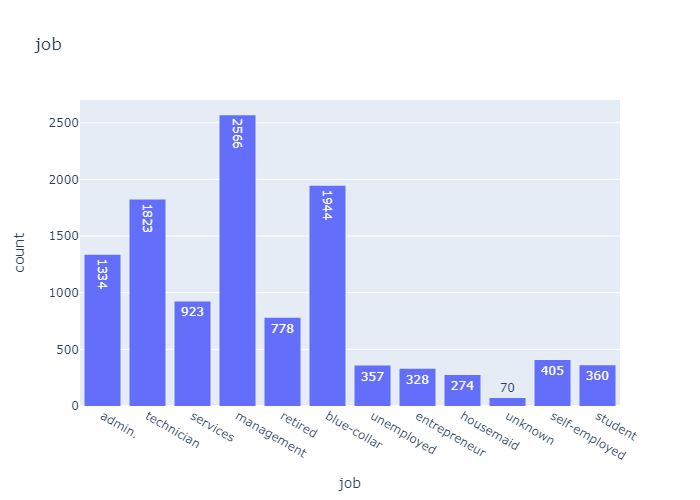

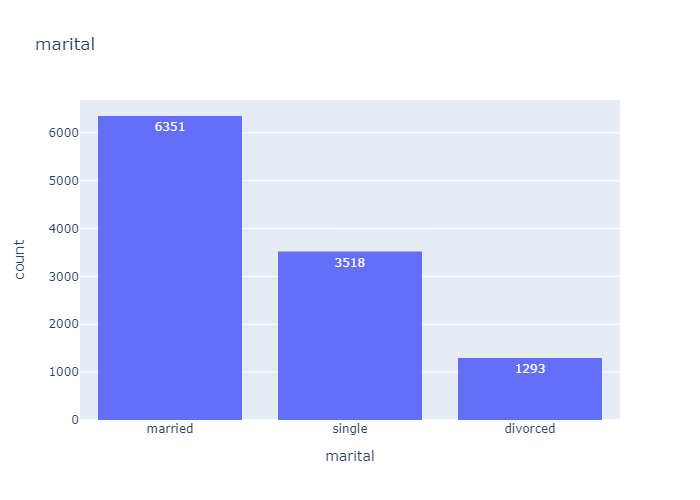

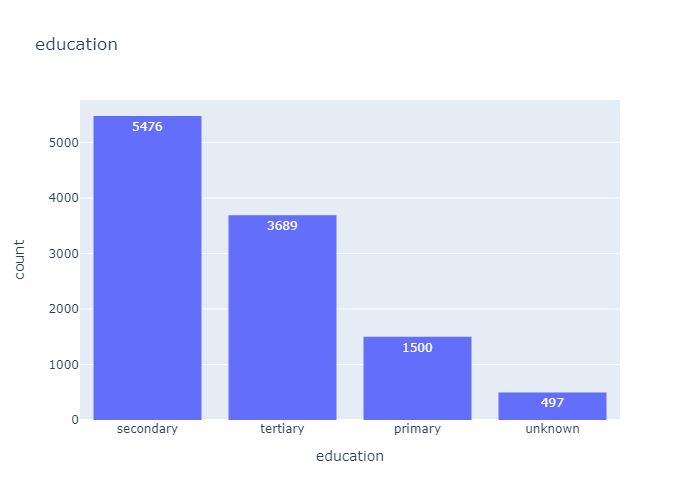

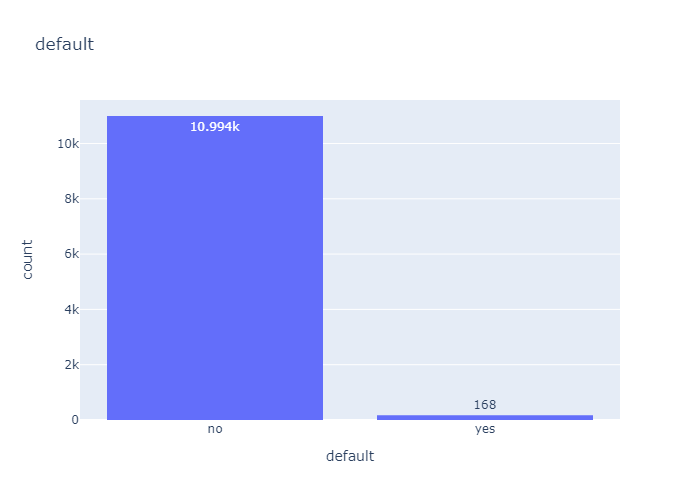

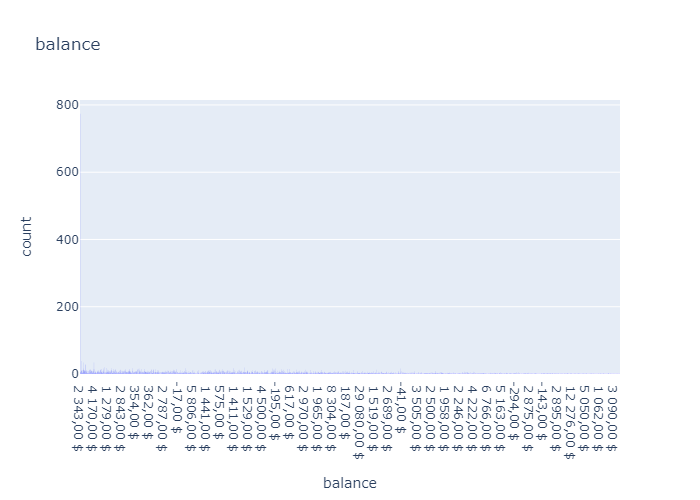

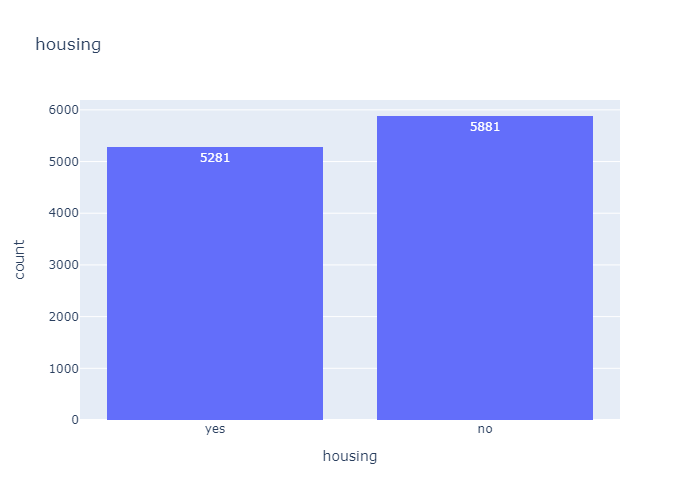

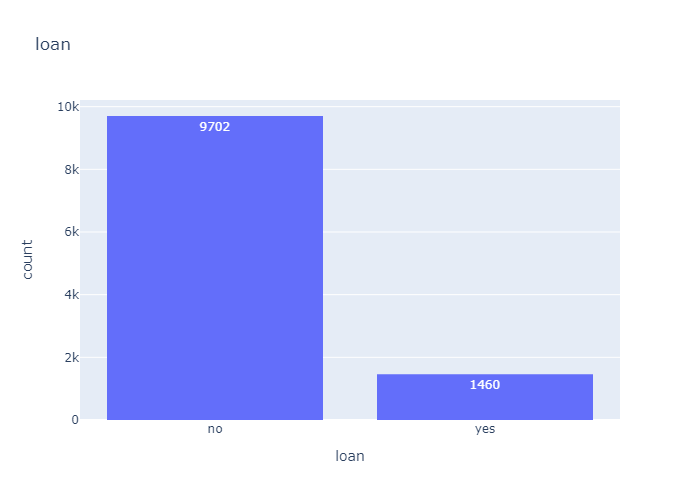

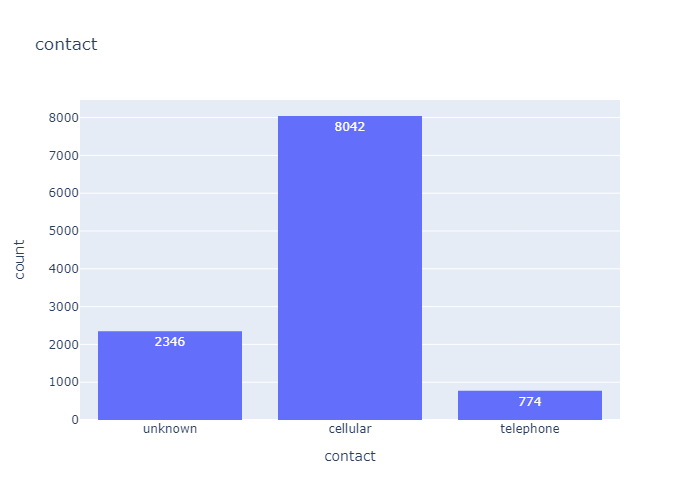

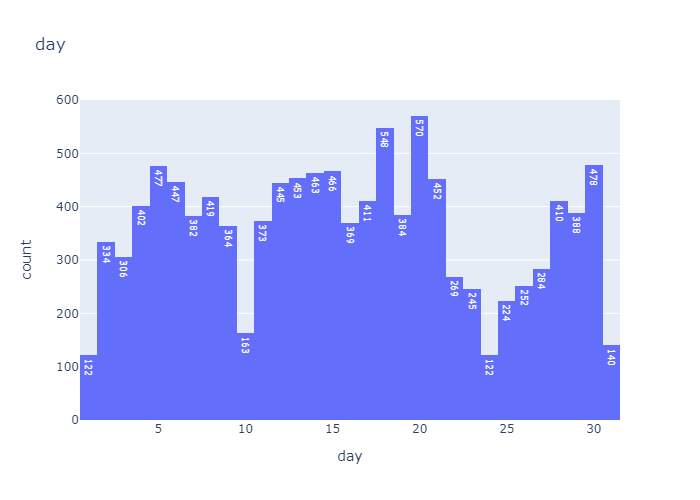

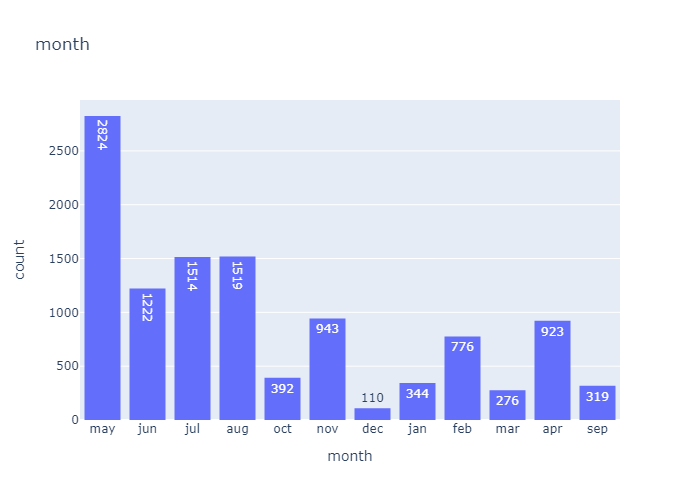

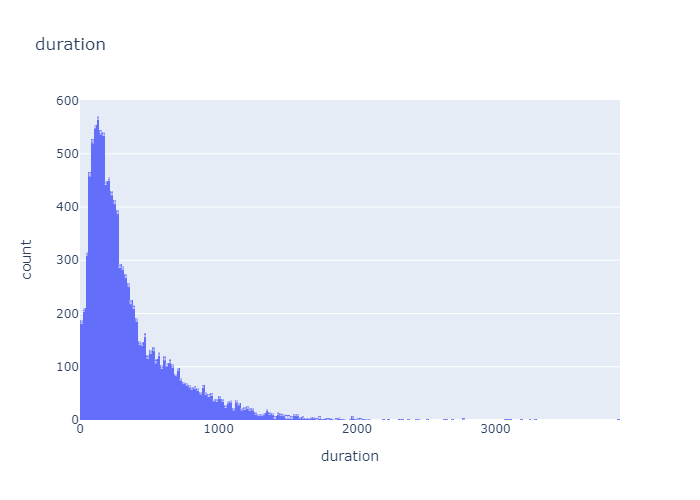

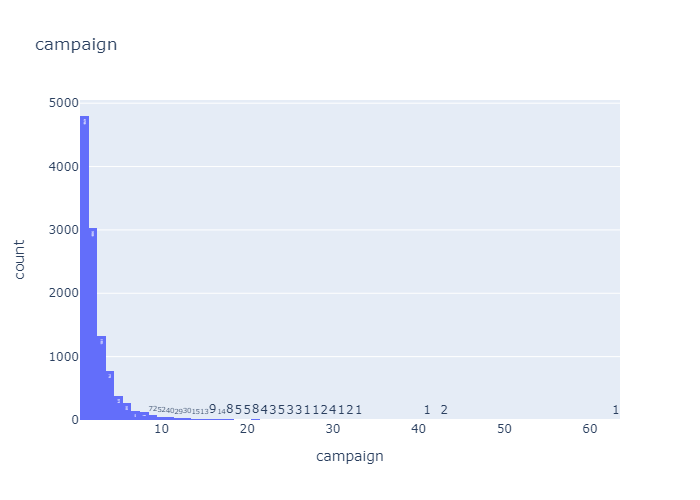

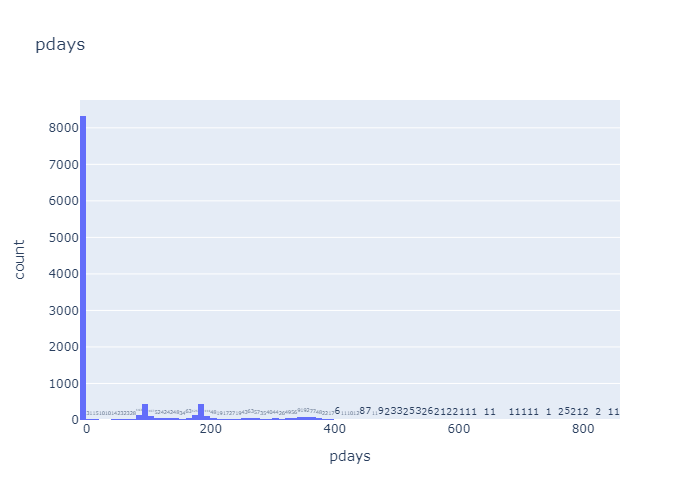

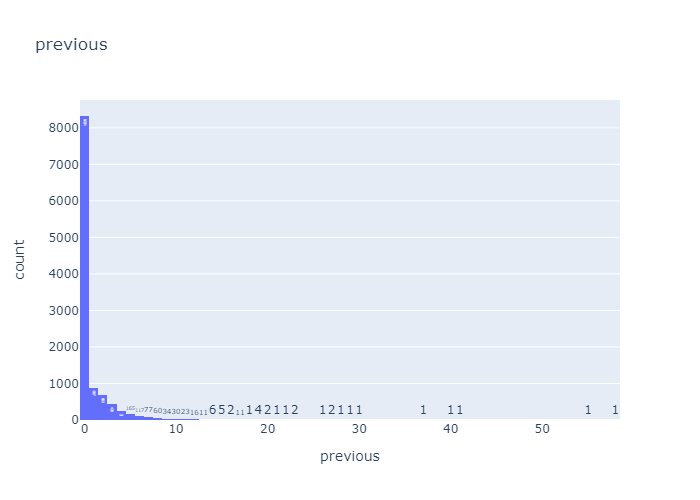

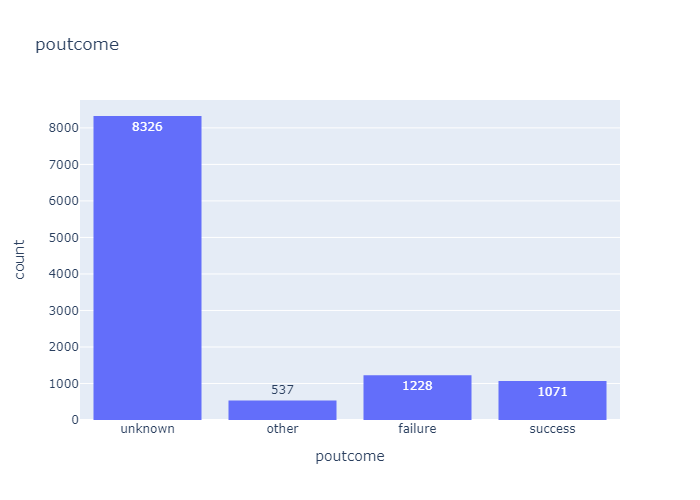

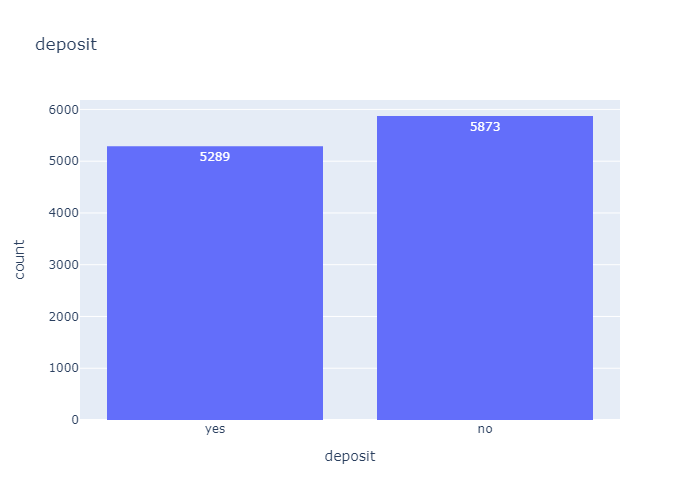

In [7]:
# визуализируем распределение признаков в наборе данных
for i in list(df.columns):
    fig = px.histogram(df, x=i, title=i, text_auto=True)
    fig.show('png')

**Клиенты, принявшие участие в кампании:**

- в возрасте(age) от 18 до 95 лет, многочисленная часть от 30 до 40 лет
- большинство занято в сфере(job) в сфере management, blue-collar, technical, малочисленно - housemaid
- почти 60% семейные люди(married), 11% - разведённые(divorced)
- половина с образованием(education) secondary
- практически никто не имеет просроченной задолженности(default)
- одинаковое число клиентов, которые имеют/не имеют кредит на жильё(housing), но превалирующее большинство не имеют кредита на личные нужды(loan)

**По кампании:**

- осуществлялась с января по декабрь
- самый активный месяц по контактам с клиентами(month) был май, в разрезе месяца(day) наименьшее число контактов было в 1, 10, 24 и 31 числах месяца
- в основном длительность контактов(duration) от 40 до 300 секунд
- с клиентами в большинстве случаев связывались(campaign) до 3 раз
- с преобладающим числом клиентов контактов до текущей кампании(previous) не проводилось

### Задание 3

In [8]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].apply(lambda x: x if [x]==[np.nan] else float((x.replace(' ', '')).replace(',', '.').split('$')[0]))

### Задание 4

In [9]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())

### Задание 5

In [10]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x=='unknown' else x)
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x=='unknown' else x)

### Задание 6

In [11]:
# удалите все выбросы для признака balance методом межквартильного размаха (Тьюки)
quantile_1, quantile_3 = df['balance'].quantile(0.25), df['balance'].quantile(0.75) # вычислить 25-ый и 75-ый квантили (первый и третий квартили) 
iqr = quantile_3 - quantile_1 # вычислить межквартильное расстояние
# вычислить верхнюю и нижнюю границы Тьюки
lower_bound = quantile_1 - iqr * 1.5
upper_bound = quantile_3 + iqr * 1.5
outliers = df[(df['balance'] <= lower_bound) | (df['balance'] >= upper_bound)]
df = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)].reset_index().drop('index', axis=1)
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {df .shape[0]}')

Число выбросов по методу Тьюки: 1058
Результирующее число записей: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

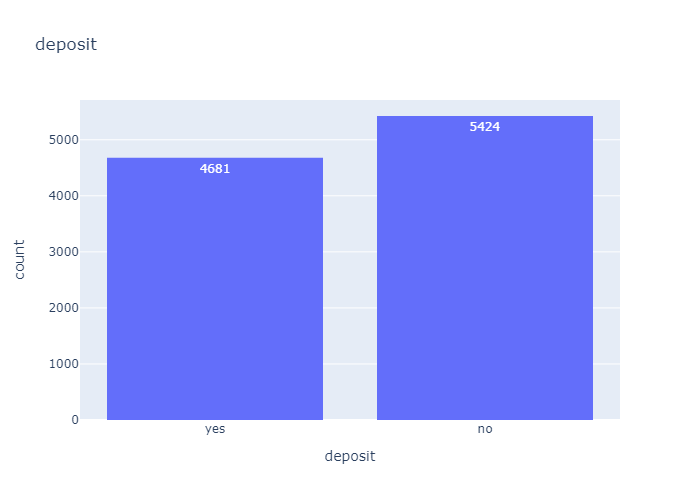

In [12]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
fig = px.histogram(df, x='deposit', title='deposit', text_auto=True)
fig.show('png')

Классы относительно сбалансированы.

### Задание 2

In [13]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df.describe()

age       balance           day      duration      campaign  \
count  10105.000000  10105.000000  10105.000000  10105.000000  10105.000000   
mean      40.895497    807.653538     15.590302    368.742603      2.517170   
std       11.734931    994.151966      8.441510    346.651524      2.707159   
min       18.000000  -2049.000000      1.000000      2.000000      1.000000   
25%       32.000000     95.000000      8.000000    137.000000      1.000000   
50%       38.000000    445.000000     15.000000    252.000000      2.000000   
75%       48.000000   1227.000000     22.000000    490.000000      3.000000   
max       95.000000   4063.000000     31.000000   3881.000000     43.000000   

              pdays      previous  
count  10105.000000  10105.000000  
mean      51.319644      0.816230  
std      109.644179      2.243795  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%        2.000000      1.000000  
max      854.000000     58.000000

In [14]:
# проведём замену значений целевого признака deposit на булевые: 1 - 'yes', 0 - 'no'
df['deposit'] = df['deposit'].apply(lambda x:int(1) if x == 'yes' else int(0))

Визуализируем зависимости целевого признака(deposit - клиенты открывшие депозит) от количественных переменных. Сделаем промежуточные выводы.

**1. AGE(возраст)**

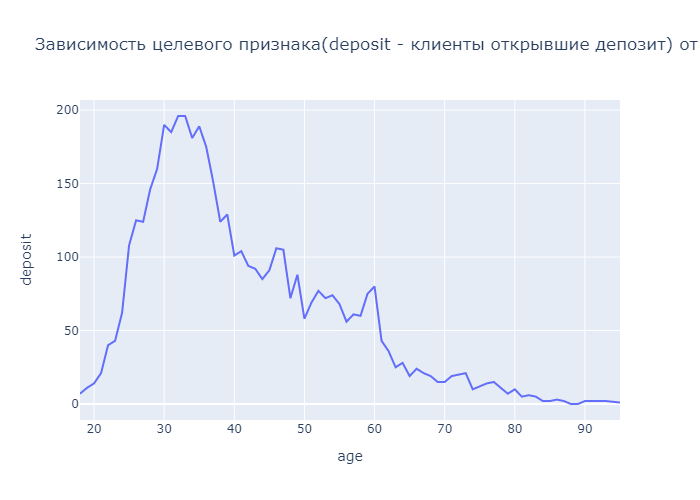

In [15]:
fig = px.line(pd.DataFrame(df.groupby('age')['deposit'].sum()).reset_index(), x='age', y='deposit', title='Зависимость целевого признака(deposit - клиенты открывшие депозит) от возраста(age)')
fig.show('png')

Признак возраст имеет распределение в диапазоне от 18 до 95 лет. На графике видно, что начиная от 18 лет резко возрастает в абсолютном значении количество открываемых депозитов клиентами банка достигая пика при age=31-33 года, далее достигнув возраста 36 лет - только плавно падая.

**2. DAY(день, в который был последний контакт)**

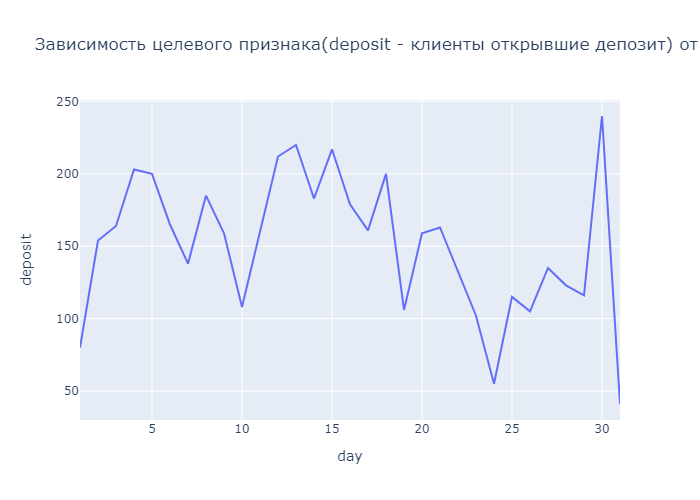

In [16]:
fig = px.line(pd.DataFrame(df.groupby('day')['deposit'].sum()).reset_index(), x='day', y='deposit', title='Зависимость целевого признака(deposit - клиенты открывшие депозит) от дня месяца(day), в который был последний контакт')
fig.show('png')

Видим локальные пики в конце месяца(30 день), в середине месяца(с 12-18 дни), в начале месяца(4-5 дни), а также локальные минимумы: первое и последнее дни месяца, 10 день месяца, 19 и 24 дни.
Возможно это связано с получение в пиковые дни доходов клиентами(заработной платы, пенсионных/социальных выплат) и промежутков соответсвующие минимумам.

**3. DURATION(продолжительность контакта в секундах)**

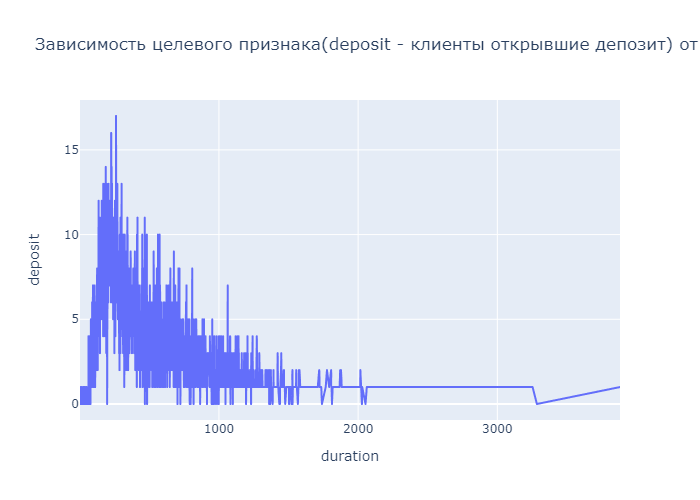

In [17]:
fig = px.line(pd.DataFrame(df.groupby('duration')['deposit'].sum()).reset_index(), x='duration', y='deposit', title='Зависимость целевого признака(deposit - клиенты открывшие депозит) от продолжительность контакта в секундах(duration)')
fig.show('png')

Видим, что увеличение продолжительности контакта увеличивает целевую переменную приблизительно до 300 секунд, далее идёт падение. Можно заметить резанность графика - разброс количества открытых депозитов при определённой продолжительности - что говорит о неединственном факторе влияющем на целевой признак и/или влияющий на него слабо.

**4. CAMPAIGN(количество контактов с этим клиентом в течение текущей кампании)**

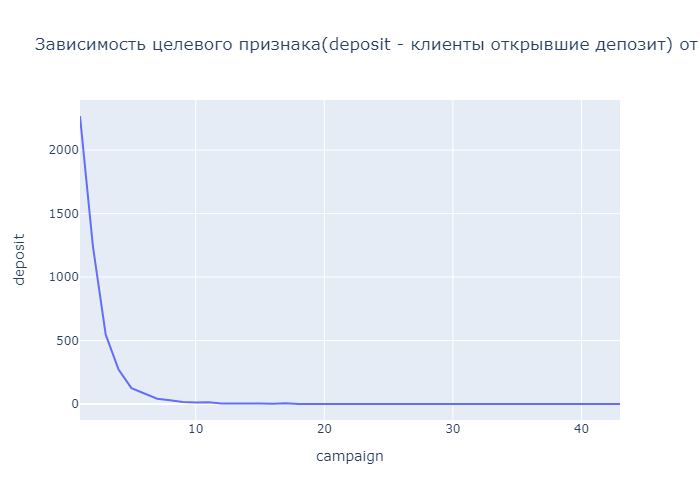

In [18]:
fig = px.line(pd.DataFrame(df.groupby('campaign')['deposit'].sum()).reset_index(), x='campaign', y='deposit', title='Зависимость целевого признака(deposit - клиенты открывшие депозит) от количество контактов с этим клиентом в течение текущей кампании(campaign)')
fig.show('png')

График зависимости показывает, что возможно необходимо ограничиться до 3-4 контактов с клиентом.

**5. PREVIOUS(количество контактов до текущей кампании)**

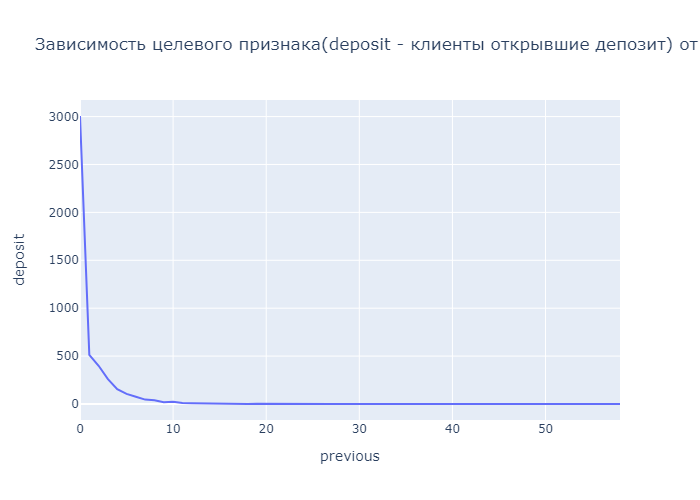

In [19]:
fig = px.line(pd.DataFrame(df.groupby('previous')['deposit'].sum()).reset_index(), x='previous', y='deposit', title='Зависимость целевого признака(deposit - клиенты открывшие депозит) от количество контактов до текущей кампании(previous)')
fig.show('png')

Чем меньше контактов было с клиентом до текущей кампании, тем ввыше шанс открытия депозита клиентом. При контактак более 5 шансы открытия депозита становятся нулевыми.

### Задание 3

In [20]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
df.describe(include='object')
#постройте визуализации, иллюстрирующие результаты

job  marital  education default housing   loan   contact  \
count        10105    10105      10105   10105   10105  10105     10105   
unique          11        3          3       2       2      2         3   
top     management  married  secondary      no      no     no  cellular   
freq          2315     5715       5517    9939    5243   8712      7283   

        month poutcome  
count   10105    10105  
unique     12        4  
top       may  unknown  
freq     2617     7570

**6. JOB(сфера занятости)**

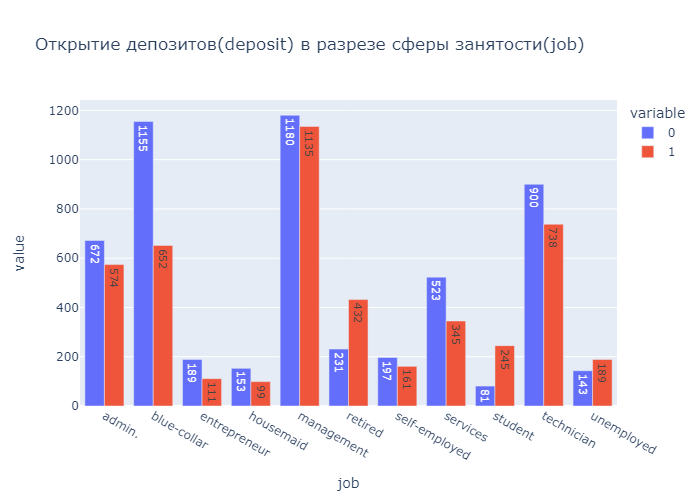

In [21]:
fig = px.bar(df.pivot_table(
    values='day',
    index='job',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).reset_index(), x='job', y=[0,1],
             orientation='v',
             text_auto=True,
             barmode='group',
             title='Открытие депозитов(deposit) в разрезе сферы занятости(job)')
fig.show('png')

Имеется тенденция к согласию открыть депозит у клиентов, находящихся на пенсии(retired), среди студентов(student), безработных(unemployed). Больше всего отказываются: клиенты, в рабочих специальностях(blue-collar), предприниматели(entrepreneur), занятые в сфере обслуживания(housemaid).

**7. MARITAL(семейное положение)**

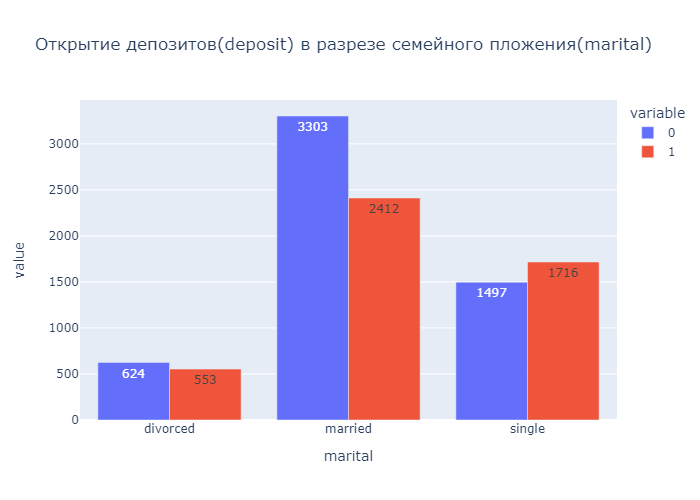

In [22]:
fig = px.bar(df.pivot_table(
    values='day',
    index='marital',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).reset_index(), x='marital', y=[0,1],
             orientation='v',
             text_auto=True,
             barmode='group',
             title='Открытие депозитов(deposit) в разрезе семейного пложения(marital)')
fig.show('png')

При семейном положении холост(single) есть тенденция открывать депозит, а не отказываться от его открытия.

**8. EDUCATION(уровень образования)**

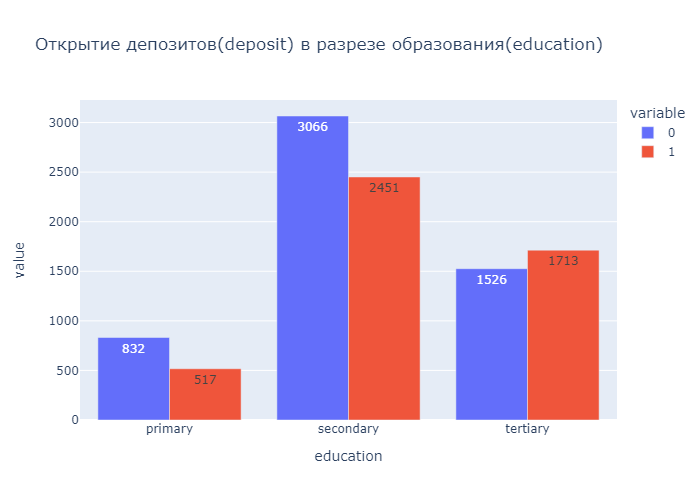

In [23]:
fig = px.bar(df.pivot_table(
    values='day',
    index='education',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).reset_index(), x='education', y=[0,1],
             orientation='v',
             text_auto=True,
             barmode='group',
             title='Открытие депозитов(deposit) в разрезе образования(education)')
fig.show('png')

Прослеживается положительная тенденция открытия депозита клиентов с уровнем образования tertiary.

**9. HOUSING(имеется ли кредит на жильё)**

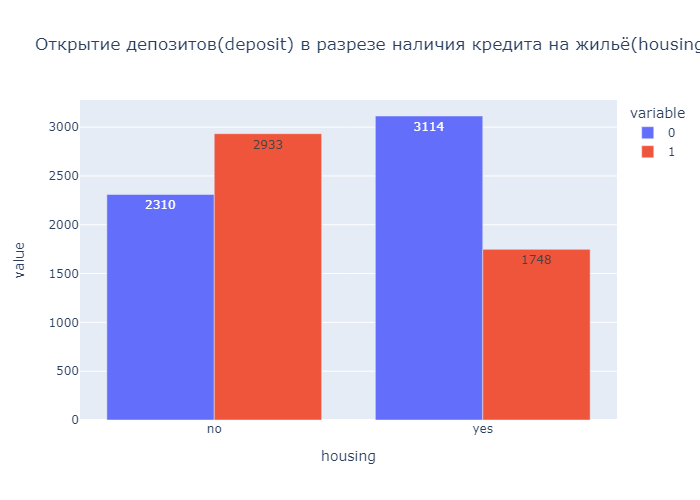

In [24]:
fig = px.bar(df.pivot_table(
    values='day',
    index='housing',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).reset_index(), x='housing', y=[0,1],
             orientation='v',
             text_auto=True,
             barmode='group',
             title='Открытие депозитов(deposit) в разрезе наличия кредита на жильё(housing)')
fig.show('png')

Видна явная тенденция, что клиенты не обременённые кредитом на жильём в большинстве случаев соглашаются на открытие депозитов, чем те, у которых имеется кредит, что говорит о наличии у них свободных средств.

**10. MONTH(месяц, в котором был последний контакт)**

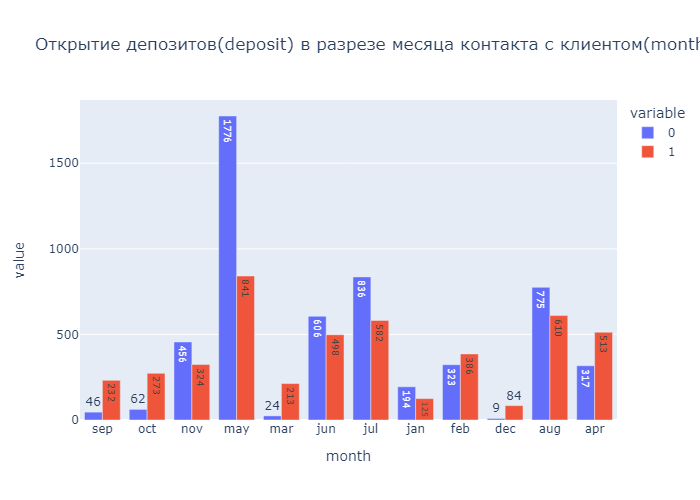

In [25]:
fig = px.bar(df.pivot_table(
    values='day',
    index='month',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).sort_index(ascending=False).reset_index(), x='month', y=[0,1],
             orientation='v',
             text_auto=True,
             barmode='group',
             title='Открытие депозитов(deposit) в разрезе месяца контакта с клиентом(month)')
fig.show('png')

Больше всего контактов было совершено в мае месяце, положительная тенденция в открытии депозитов была отмечена в феврале, марте, апреле, сентябре, октябре, декабре. 

**11. POUTCOME(результат прошлой маркетинговой кампании)**

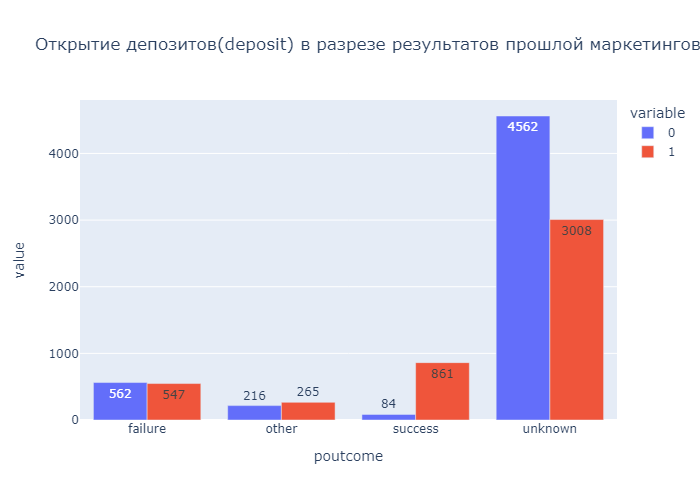

In [26]:
fig = px.bar(df.pivot_table(
    values='day',
    index='poutcome',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).reset_index(), x='poutcome', y=[0,1],
             orientation='v',
             text_auto=True,
             barmode='group',
             title='Открытие депозитов(deposit) в разрезе результатов прошлой маркетинговой кампании(poutcome)')
fig.show('png')

Клиенты, согласившиеся открыть депозит по результатам прошлой кампании(success) охотно открывают депозит и в результате новой кампании т.е. становятся лояльными. Из клиентов отказавшиеся от открытия депозита в прошлу кампанию - половина отказывается открывать депозит и в новую кампанию.

### Задание 4

In [27]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
df.groupby('poutcome')['deposit'].value_counts()

poutcome  deposit
failure   0           562
          1           547
other     1           265
          0           216
success   1           861
          0            84
unknown   0          4562
          1          3008
Name: deposit, dtype: int64

Для клиентов группы poutcome(succes) в предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

### Задание 5

In [28]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
percent_failure = round((df.groupby('month')['deposit'].count() - df.groupby('month')['deposit'].sum()) / df.groupby('month')['deposit'].count() * 100).sort_values(ascending=False)
print(f'В {percent_failure.index[0]} месяце больше всего отказывались от открытия депозита.')

В may месяце больше всего отказывались от открытия депозита.


### Задание 6

In [29]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def create_age_group(age):
    """ Разбивает клиентов на возрастные группы

    Args:
        age (int): возраст

    Returns:
        age_group(object): возрастная группа
    """
    if age < 30:
        age_group = '<30'
    elif 30 <= age < 40:
        age_group = '30-40'
    elif 40 <= age < 50:
        age_group = '40-50'
    elif 50 <= age < 60:
        age_group = '50-60'
    else:
        age_group = '60+'
    return age_group

df['age_group'] = df['age'].apply(create_age_group)

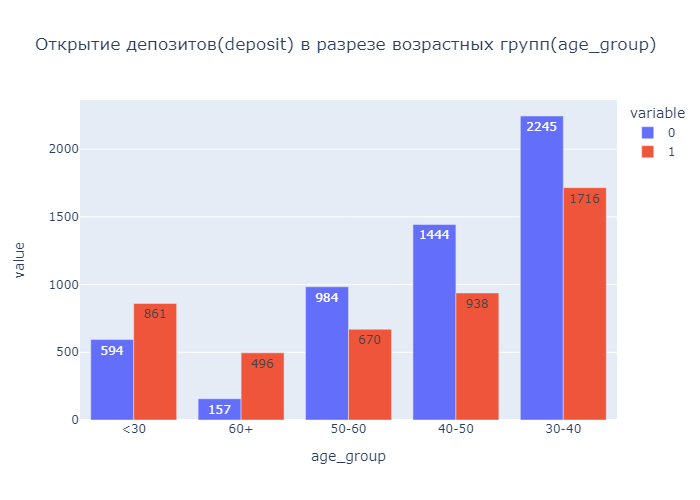

In [30]:
fig = px.bar(df.pivot_table(
    values='day',
    index='age_group',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).sort_index(ascending=False).reset_index(), x='age_group', y=[0,1],
             orientation='v',
             text_auto=True,
             barmode='group',
             title='Открытие депозитов(deposit) в разрезе возрастных групп(age_group)')
fig.show('png')

Две возрастные группы, которые более склонны открывать депозит - <30 и 60+

### Задание 7

In [31]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
round(df.pivot_table(
    values='day',
    index=['education', 'marital'],    
    columns='deposit',
    aggfunc='count',
    fill_value=0)[1]/df.groupby(['education', 'marital'])['deposit'].count() * 100)

education  marital 
primary    divorced    51.0
           married     35.0
           single      45.0
secondary  divorced    43.0
           married     41.0
           single      50.0
tertiary   divorced    52.0
           married     49.0
           single      59.0
dtype: float64

Клиенты, которые чаще открывают депозит имеют уровень образования tertiary и семейный статус single или divorced, а также с образованием primary и семейным статусом divorced. 

Меньше всего -  с комбинацией primary/married.

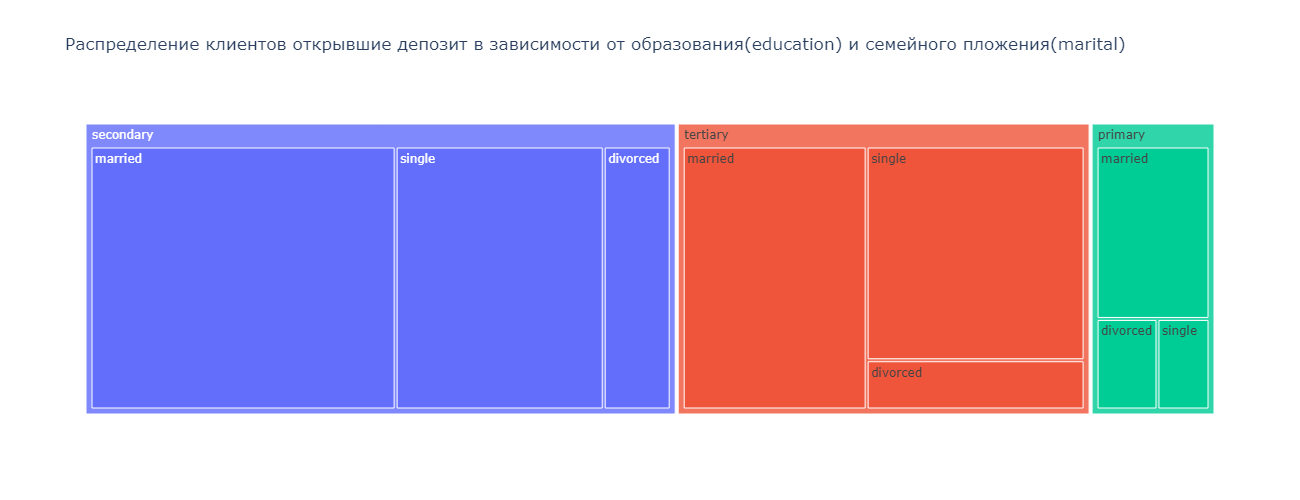

In [32]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
p1 = df[df['deposit']==1]
p1 = pd.DataFrame(p1.pivot_table(
    values='age',
    index=['education', 'marital'],    
    columns='deposit',
    aggfunc='count',
    fill_value=0))

fig = px.treemap(
    data_frame=p1, #DataFrame
    path=[p1.index.get_level_values(0), p1.index.get_level_values(1)], #категориальный признак, для которого строится график
    values=1, #параметр, который сравнивается
    height=500, #высота
    width=1300, #ширина
    title='Распределение клиентов открывшие депозит в зависимости от образования(education) и семейного пложения(marital)' #заголовок
)
#отображаем график
fig.show('png')


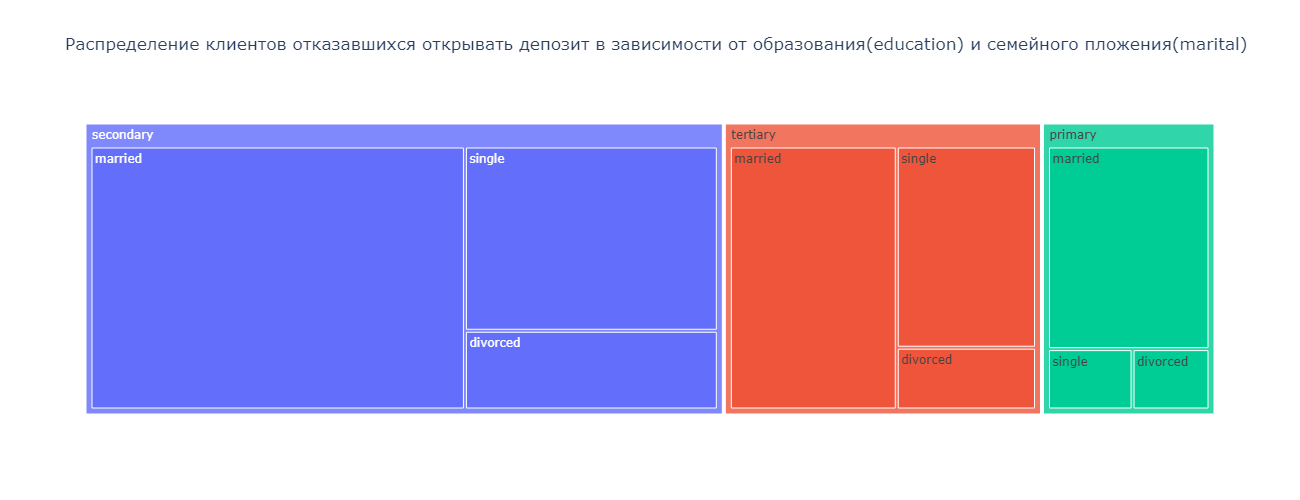

In [33]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто отказался открыть депозит)
p2 = df[df['deposit']==0]
p2 = pd.DataFrame(p2.pivot_table(
    values='age',
    index=['education', 'marital'],    
    columns='deposit',
    aggfunc='count',
    fill_value=0))

fig = px.treemap(
    data_frame=p2, #DataFrame
    path=[p2.index.get_level_values(0), p2.index.get_level_values(1)], #категориальный признак, для которого строится график
    values=0, #параметр, который сравнивается
    height=500, #высота
    width=1300, #ширина
    title='Распределение клиентов отказавшихся открывать депозит в зависимости от образования(education) и семейного пложения(marital)' #заголовок
)
#отображаем график
fig.show('png')

Пересечение в двух категориях является самым многочисленным для клиентов и согласившиеся взять депозит и отказавшихся: с семейные положением married и образованием secondary.

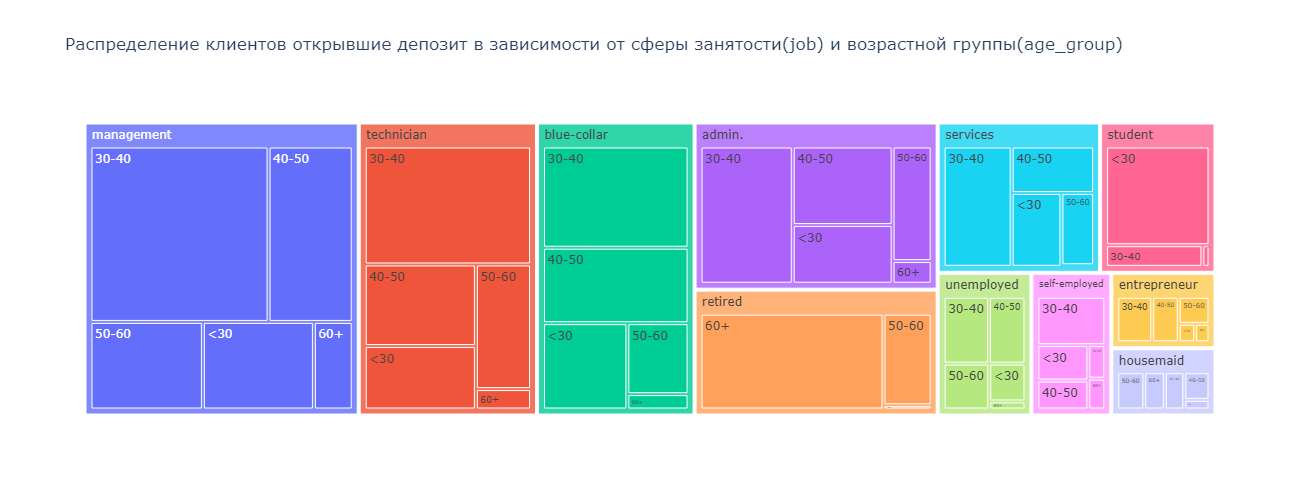

In [34]:
# постройте сводную таблицу, чтобы определить люди в какой сфере занятости и возрастной группы наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
p3 = df[df['deposit']==1]
p3 = pd.DataFrame(p3.pivot_table(
    values='education',
    index=['job', 'age_group'],    
    columns='deposit',
    aggfunc='count',
    fill_value=0))

fig = px.treemap(
    data_frame=p3, #DataFrame
    path=[p3.index.get_level_values(0), p3.index.get_level_values(1)], #категориальный признак, для которого строится график
    values=1, #параметр, который сравнивается
    height=500, #высота
    width=1300, #ширина
    title='Распределение клиентов открывшие депозит в зависимости от сферы занятости(job) и возрастной группы(age_group)' #заголовок
)
#отображаем график
fig.show('png')

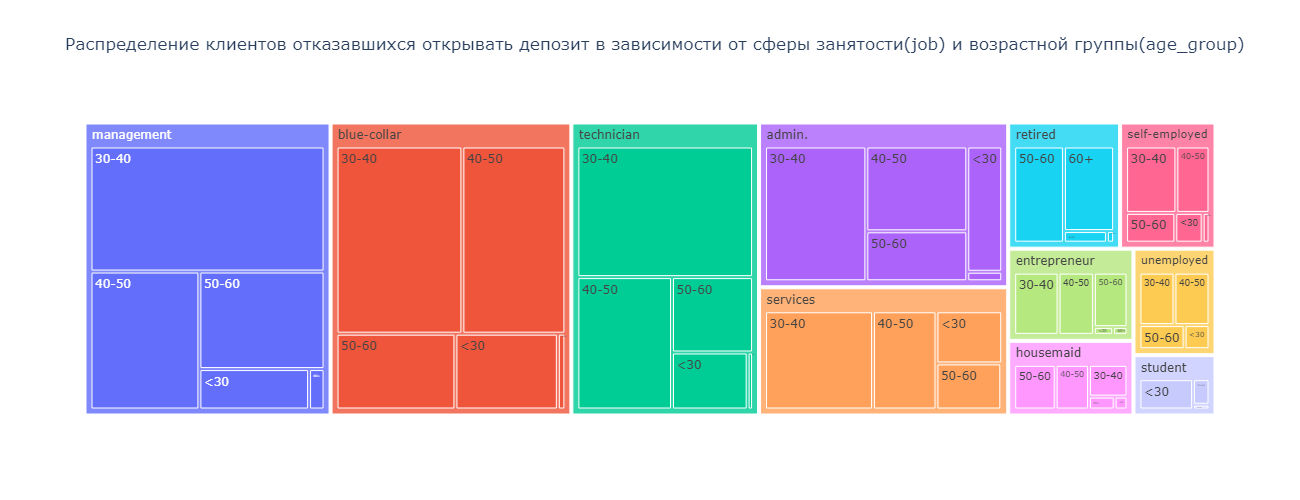

In [35]:
# постройте сводную таблицу, чтобы определить люди в какой сфере занятости и возрастной группы наиболее многочисленны
#(если рассматривать тех, кто отказался открыть депозит)
p4 = df[df['deposit']==0]
p4 = pd.DataFrame(p4.pivot_table(
    values='education',
    index=['job', 'age_group'],    
    columns='deposit',
    aggfunc='count',
    fill_value=0))

fig = px.treemap(
    data_frame=p4, #DataFrame
    path=[p4.index.get_level_values(0), p4.index.get_level_values(1)], #категориальный признак, для которого строится график
    values=0, #параметр, который сравнивается
    height=500, #высота
    width=1300, #ширина
    title='Распределение клиентов отказавшихся открывать депозит в зависимости от сферы занятости(job) и возрастной группы(age_group)' #заголовок
)
#отображаем график
fig.show('png')

В обеих группах самая многочисленная категория занятых в сфере managment в возрастной группе 30-40.

## Часть 3: преобразование данных

### Задание 1

In [36]:
# преобразуйте уровни образования
label_encoder = LabelEncoder() # кодируем порядковым кодировщиком
data_educ = label_encoder.fit_transform(df['education'])
df['education_cod'] = data_educ

# преобразуйте возрастные группы
data_age = label_encoder.fit_transform(df['age_group'])
df['age_group'] = data_age

### Задание 2

In [37]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df['housing_bin'] = df['housing'].apply(lambda x: int(1) if x == 'yes' else int(0))
df['default_bin'] = df['default'].apply(lambda x: int(1) if x == 'yes' else int(0))
df['loan_bin'] = df['loan'].apply(lambda x: int(1) if x == 'yes' else int(0))

### Задание 3

In [38]:
# создайте дамми-переменные
df = pd.get_dummies(df, columns=['job', 'marital', 'contact', 'month', 'poutcome'], prefix=['job', 'marital', 'contact', 'month', 'poutcome'])
df = df.drop(columns=['age', 'education', 'default', 'loan', 'housing'])

### Задание 4

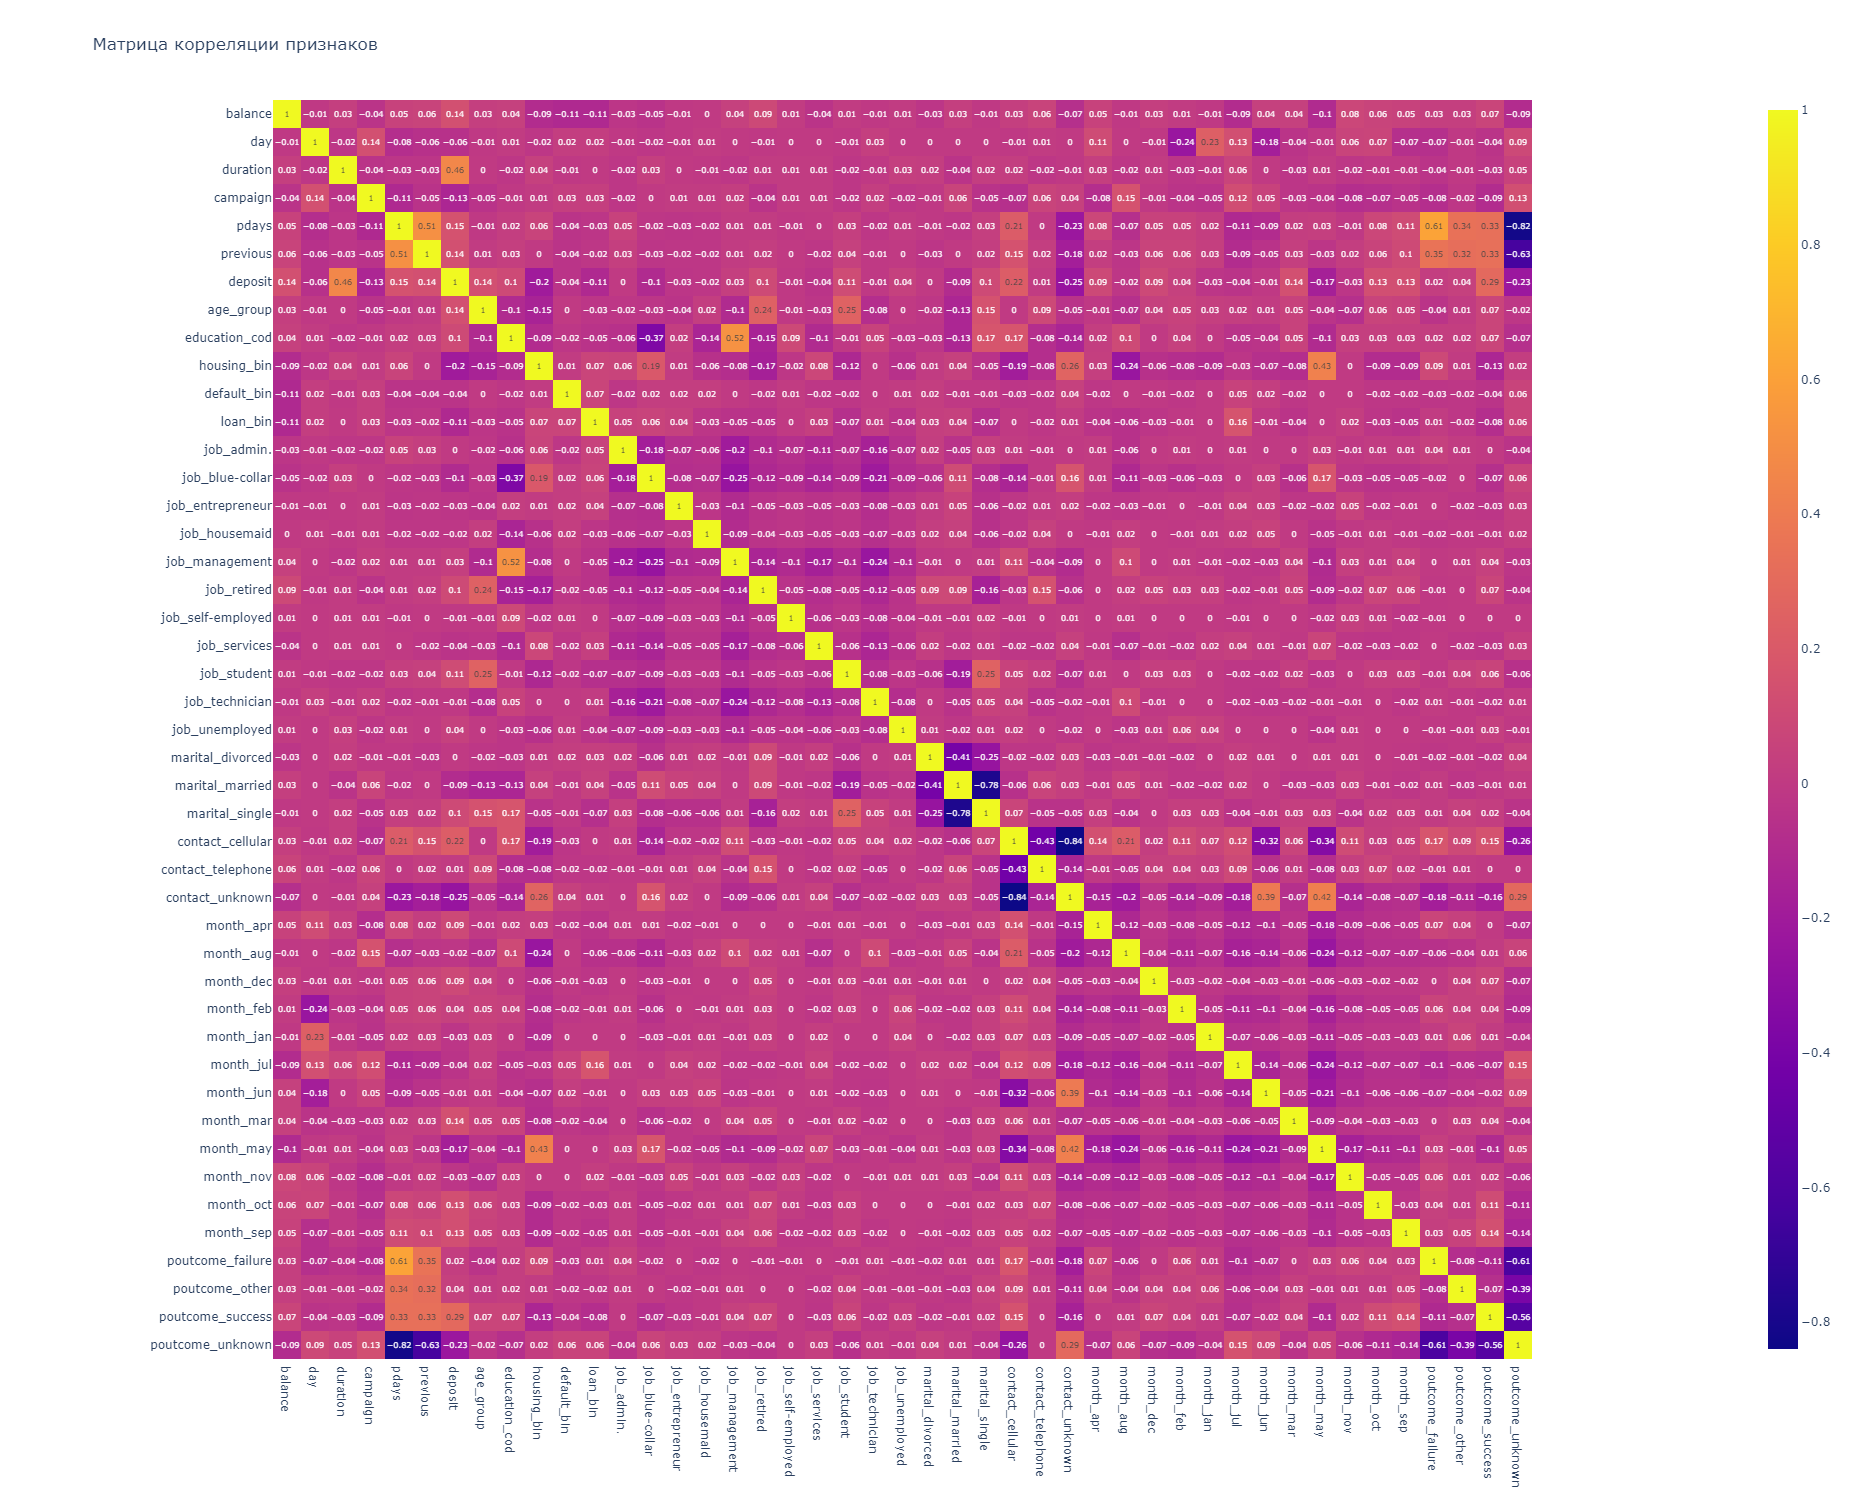

In [39]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
corrs = round(df.corr(), 2)
fig = px.imshow(
    img=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    text_auto=True,    
    title='Матрица корреляции признаков',
    width=1850,
    height=1500
    )
fig.show('png')

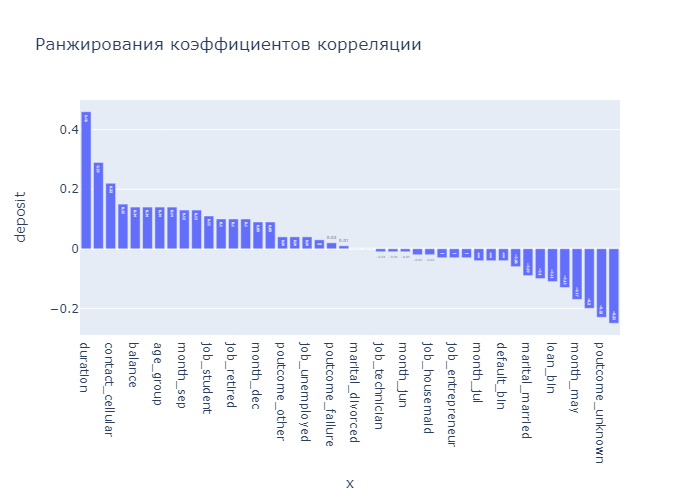

In [40]:
corrs = round(df.corr(), 2).drop('deposit', axis=0)

fig = px.bar(corrs['deposit'].sort_values(ascending=False),
             x=list(corrs['deposit'].sort_values(ascending=False).index),
             y='deposit',
             text_auto=True,
             title='Ранжирования коэффициентов корреляции'
             )

fig.show('png')  

Мультиколлинеарность признаков отсутсвует. 

Признаки наиболее коррелирующие с целевой переменной:
- продолжительность контакта в секундах(duration)
- успех результата прошлой маркетинговой кампании(poutcome_success)
- контакт с клиентом по сотовому(contact_cellular)

### Задание 5

In [41]:
# разделим датафрейм на целевой и предикты
X = df.drop(['deposit'], axis=1)
y = df['deposit']
# разделим датафрейм на тестовые и тренировочные
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
print(f'Размер тестовой выборки X_train={X_train.shape}, y_train={y_train.shape[0]}')
print(f'Размер тестовой выборки X_test={X_test.shape}, y_test={y_test.shape[0]}')

Размер тестовой выборки X_train=(6770, 44), y_train=6770
Размер тестовой выборки X_test=(3335, 44), y_test=3335


### Задание 6

In [42]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(score_func = f_classif, k=15)
selector.fit(X_train, y_train)
selector.get_feature_names_out()
selector_col = list(selector.get_feature_names_out())
selector_col

['balance',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_group',
 'housing_bin',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

### Задание 7

In [43]:
# нормализуйте данные с помощью minmaxsxaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scal = scaler.fit_transform(X_train)
X_train_scal = pd.DataFrame(X_train_scal, columns=X_train.columns)
X_test_scal = scaler.transform(X_test)
X_test_scal = pd.DataFrame(X_test_scal, columns=X_test.columns)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [44]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_model = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
log_model.fit(X_train_scal, y_train)
y_test_pred = log_model.predict(X_test_scal)
y_train_pred = log_model.predict(X_train_scal)
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')

Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.81      0.86      0.83      1790
           1       0.82      0.77      0.80      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.81      0.81      3335
weighted avg       0.82      0.82      0.82      3335

Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      3634
           1       0.85      0.80      0.82      3136

    accuracy                           0.84      6770
   macro avg       0.84      0.84      0.84      6770
weighted avg       0.84      0.84      0.84      6770



### Задание 2

In [45]:
# обучите решающие деревья, настройте максимальную глубину
tree_model = tree.DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=6)
tree_model.fit(X_train_scal, y_train)
y_test_pred = tree_model.predict(X_test_scal)
y_train_pred = tree_model.predict(X_train_scal)
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')

Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.85      0.78      0.81      1790
           1       0.76      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.80      3335
weighted avg       0.81      0.81      0.81      3335

Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       0.87      0.79      0.83      3634
           1       0.78      0.86      0.82      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770



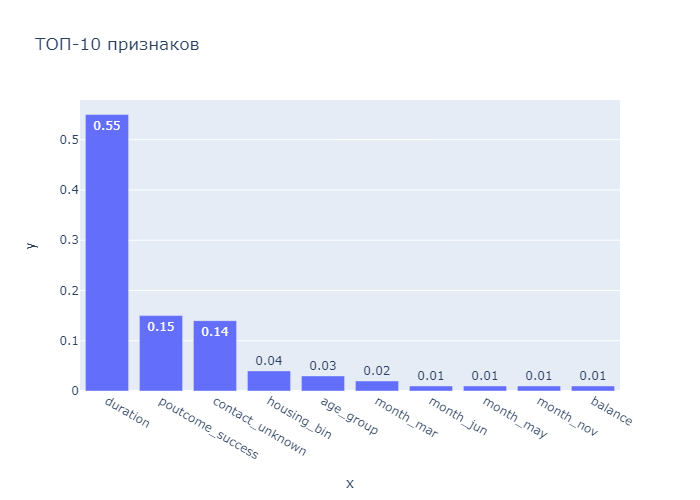

In [46]:
# визуализируем важные признаки в дереве решений
oo = pd.DataFrame([tree_model.feature_importances_], columns=X_train_scal.columns)
fig = px.bar(x = list(oo.loc[0].sort_values(ascending=False)[0:10].index),
    y=round(oo.loc[0].sort_values(ascending=False)[0:10], 2),
    text_auto=True,
    title='ТОП-10 признаков'    
)
fig.show('png')

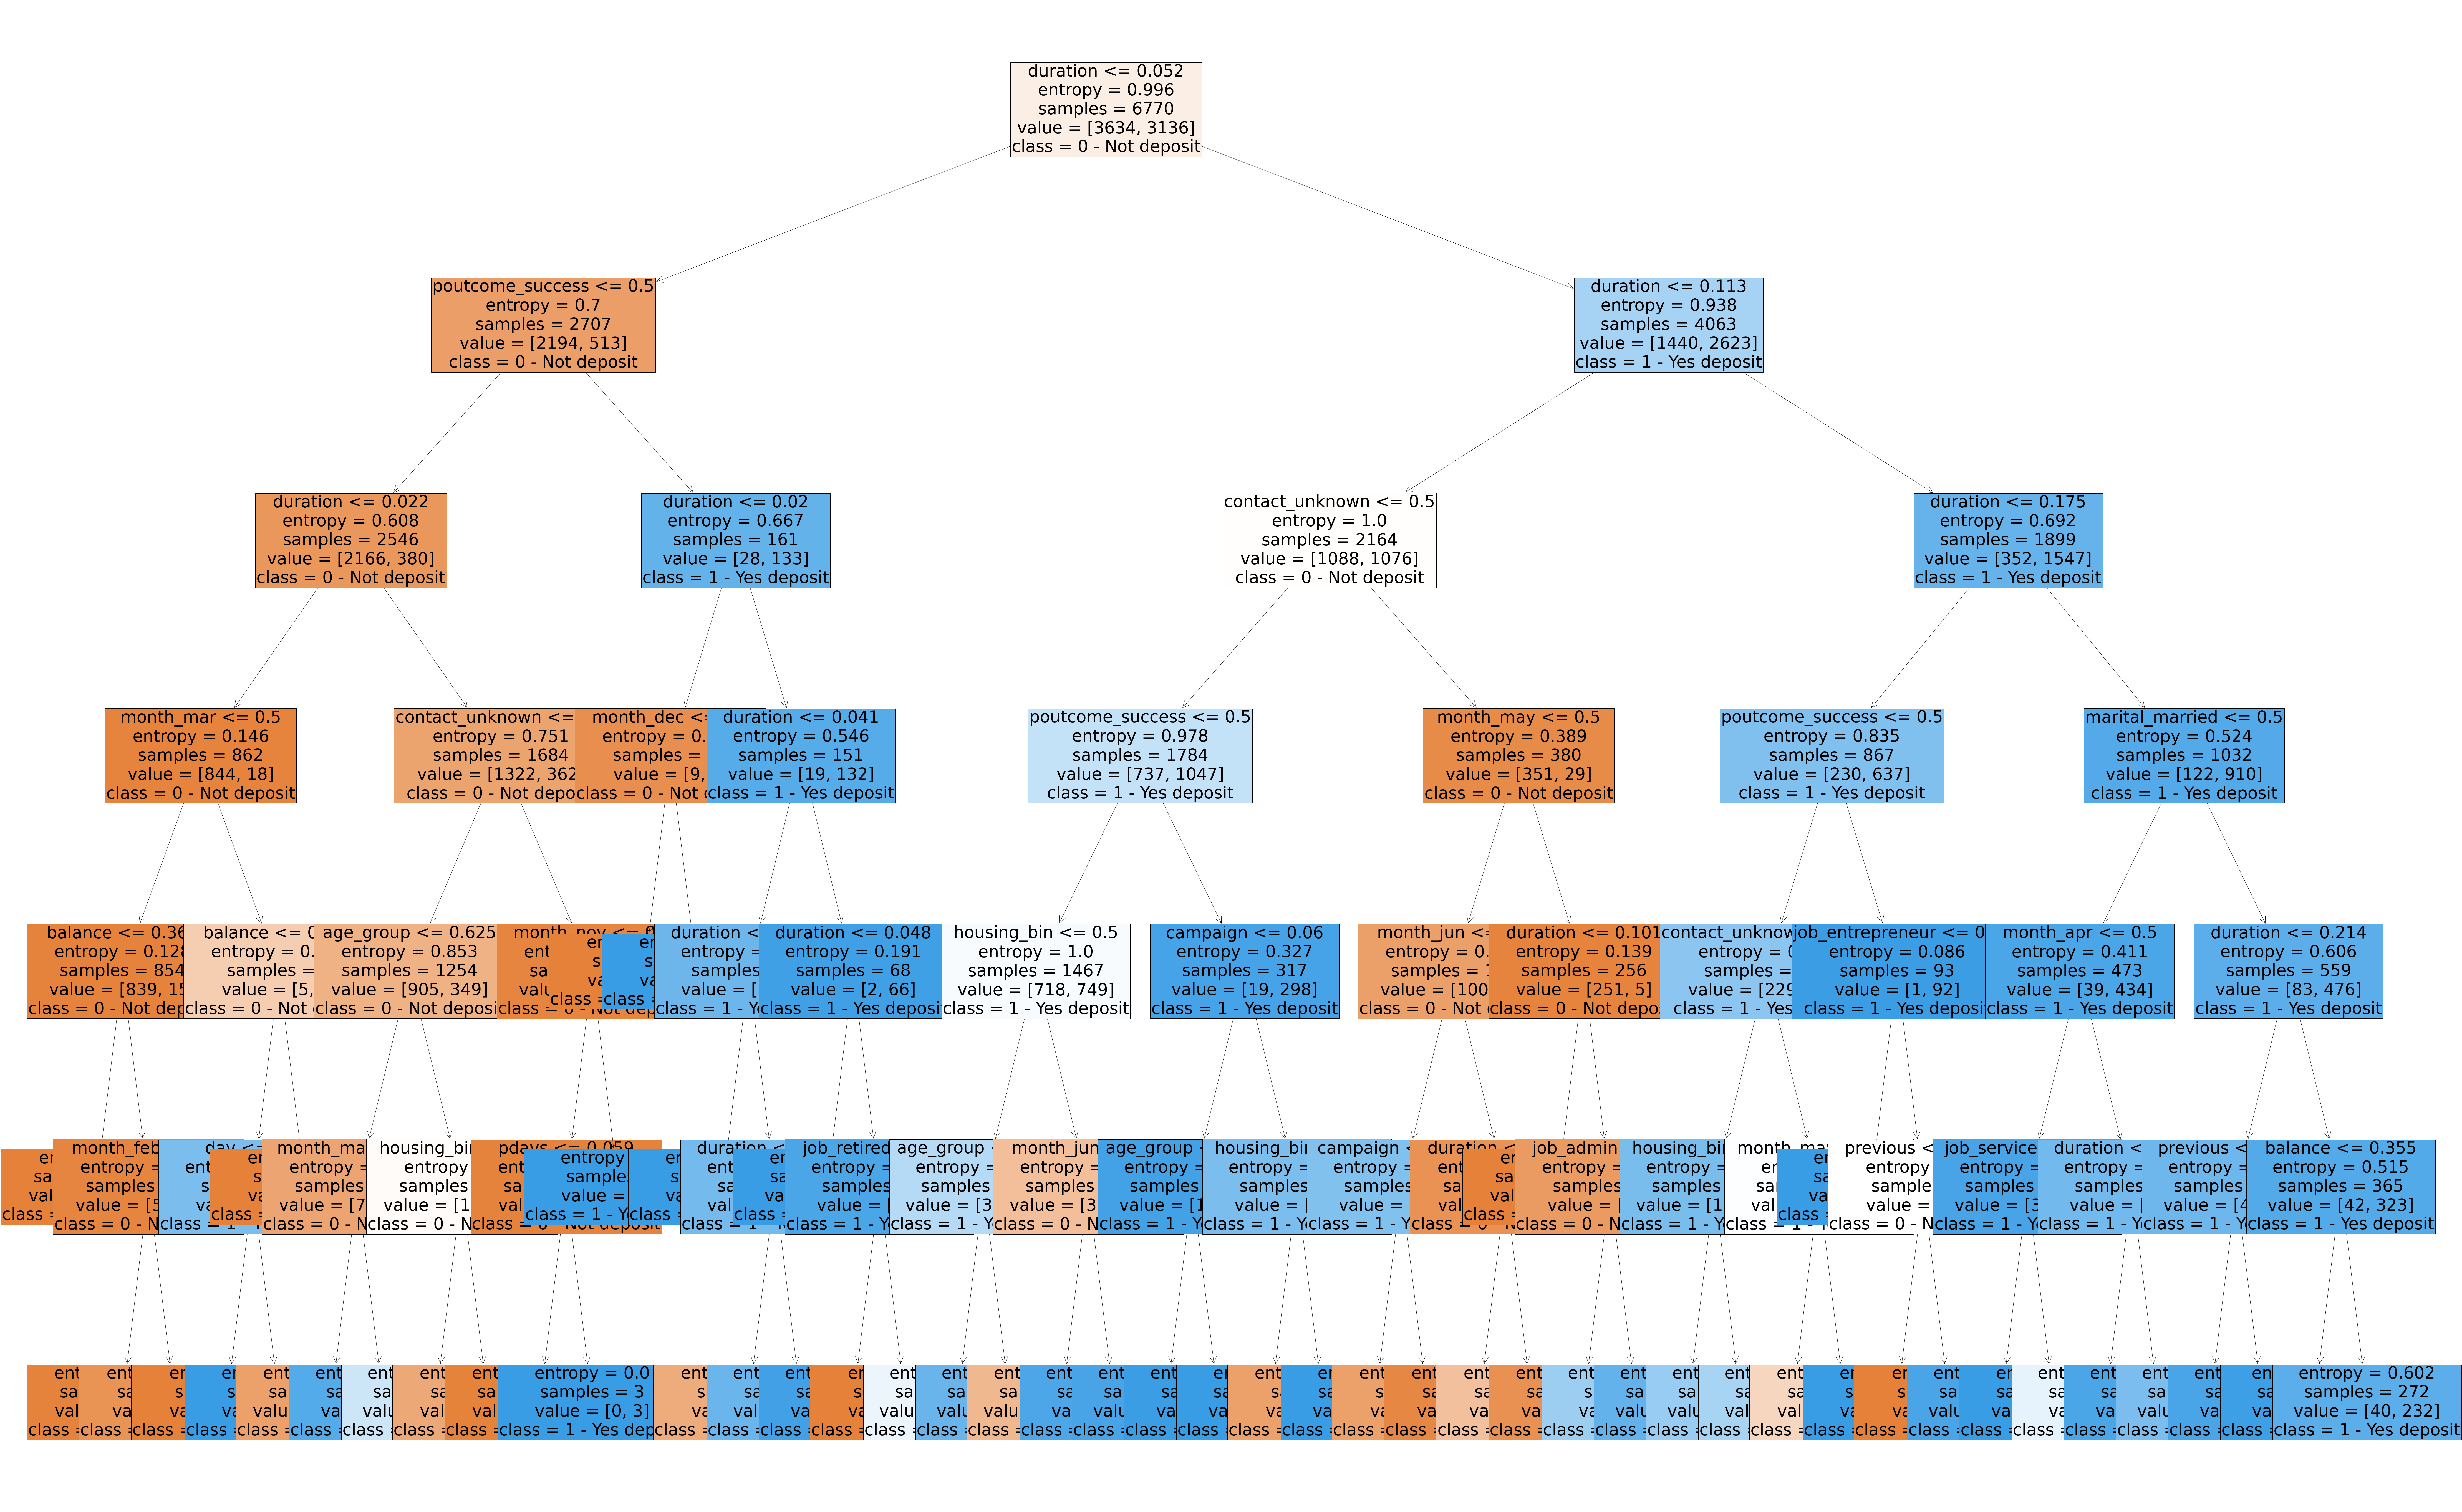

In [47]:
#Создаём фигуру для визуализации графа
fig = plt.figure(figsize=(150, 100))
#Строим граф дерева решений
tree.plot_tree(
    tree_model, #объект обученного дерева
    feature_names=X_train_scal.columns, #наименования факторов
    class_names=["0 - Not deposit", "1 - Yes deposit"], #имена классов
    filled=True, #расцветка графа
    fontsize=60    
    );

### Задание 3

In [48]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV
# задаём сетку параметров
param_grid = [
              {'min_samples_split': [2, 5, 7, 10] , # Минимальное количество выборок, необходимое для разделения внутреннего узла
              'max_depth':[3,5,7] # Максимальная глубина дерева
               }              
]

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(criterion='entropy',
        
        random_state=42, #генератор случайных чисел
        ), 
    param_grid=param_grid, 
    n_jobs = -1,
    scoring='f1'
)  

grid_search.fit(X_train_scal, y_train) 
print(f'Best Hyperparameter Values: {grid_search.best_params_}')
print(f'Best Models:{grid_search.best_estimator_}')
print(f'Best score Cross validation: {grid_search.best_score_:.3f}')
y_test_pred = grid_search.predict(X_test_scal)
y_train_pred = grid_search.predict(X_train_scal)
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')

Best Hyperparameter Values: {'max_depth': 7, 'min_samples_split': 10}
Best Models:DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_split=10,
                       random_state=42)
Best score Cross validation: 0.795
Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.80      0.84      0.82      1790
           1       0.81      0.75      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.80      0.80      3335
weighted avg       0.80      0.80      0.80      3335

Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       0.82      0.88      0.85      3634
           1       0.85      0.77      0.81      3136

    accuracy                           0.83      6770
   macro avg       0.83      0.83      0.83      6770
weighted avg       0.83      0.83      0.83      6770



# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [49]:
# обучите на ваших данных случайный лес
forest_model = ensemble.RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_leaf=5,
    criterion='gini'
)
forest_model.fit(X_train_scal, y_train)
y_train_pred = forest_model.predict(X_train_scal)
y_test_pred = forest_model.predict(X_test_scal)
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')

Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.87      0.83      0.85      1790
           1       0.81      0.86      0.83      1545

    accuracy                           0.84      3335
   macro avg       0.84      0.84      0.84      3335
weighted avg       0.84      0.84      0.84      3335

Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       0.90      0.86      0.88      3634
           1       0.85      0.89      0.87      3136

    accuracy                           0.87      6770
   macro avg       0.87      0.88      0.87      6770
weighted avg       0.88      0.87      0.87      6770



### Задание 2

In [50]:
# используйте для классификации ada-бустинг и сравните качество со случайным лесом
from sklearn.ensemble import AdaBoostClassifier
forest_model_b = ensemble.RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    max_depth=5,
    min_samples_leaf=5,
    criterion='gini'
)

ada = AdaBoostClassifier(
    base_estimator=forest_model_b,
    random_state=42,
    learning_rate=0.05,
    n_estimators=300      
)

ada.fit(X_train_scal, y_train)
y_train_pred = ada.predict(X_train_scal)
y_test_pred = ada.predict(X_test_scal)
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')

Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.88      0.84      0.86      1790
           1       0.82      0.86      0.84      1545

    accuracy                           0.85      3335
   macro avg       0.85      0.85      0.85      3335
weighted avg       0.85      0.85      0.85      3335

Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       0.91      0.88      0.90      3634
           1       0.87      0.90      0.88      3136

    accuracy                           0.89      6770
   macro avg       0.89      0.89      0.89      6770
weighted avg       0.89      0.89      0.89      6770



In [51]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    n_estimators=300,
    random_state=42,
    min_samples_leaf=5,
    learning_rate=0.05,
    max_depth=5         
)

gb.fit(X_train_scal, y_train)
y_train_pred = gb.predict(X_train_scal)
y_test_pred = gb.predict(X_test_scal)
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')

Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.88      0.84      0.86      1790
           1       0.82      0.87      0.85      1545

    accuracy                           0.85      3335
   macro avg       0.85      0.85      0.85      3335
weighted avg       0.85      0.85      0.85      3335

Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       0.93      0.90      0.92      3634
           1       0.89      0.92      0.91      3136

    accuracy                           0.91      6770
   macro avg       0.91      0.91      0.91      6770
weighted avg       0.91      0.91      0.91      6770



### Задание3

In [52]:
# объедините уже известные вам алгоритмы с помощью стекинга
from sklearn.ensemble import StackingClassifier
#Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('lr', log_model),
    ('dt',  tree_model),
    ('fm', forest_model),
    ('ada', ada)      
]

#Создаем объект класса стекинг
steg_model = StackingClassifier(
    estimators=estimators,
    final_estimator=gb)
    

steg_model.fit(X_train_scal, y_train)
y_train_pred = steg_model.predict(X_train_scal)
y_test_pred = steg_model.predict(X_test_scal)
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')

Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.88      0.83      0.85      1790
           1       0.81      0.87      0.84      1545

    accuracy                           0.85      3335
   macro avg       0.85      0.85      0.85      3335
weighted avg       0.85      0.85      0.85      3335

Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       0.93      0.87      0.90      3634
           1       0.86      0.92      0.89      3136

    accuracy                           0.90      6770
   macro avg       0.90      0.90      0.90      6770
weighted avg       0.90      0.90      0.90      6770



### Задание 4

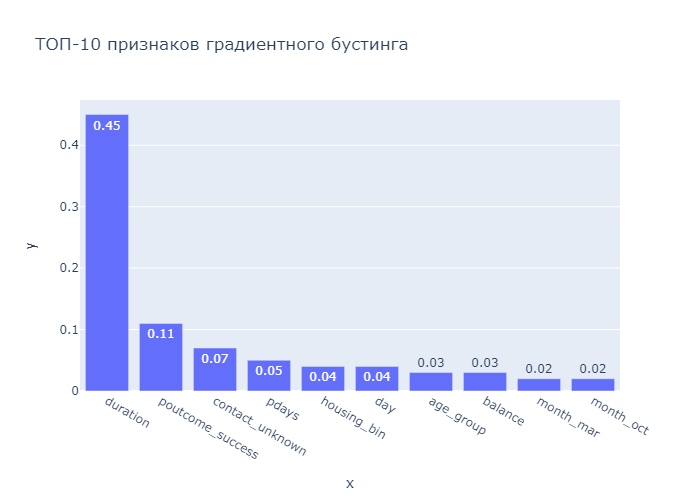

In [53]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
ooo = pd.DataFrame([gb.feature_importances_], columns=gb.feature_names_in_)
fig = px.bar(x = list(ooo.loc[0].sort_values(ascending=False)[0:10].index),
    y=round(ooo.loc[0].sort_values(ascending=False)[0:10], 2),
    text_auto=True,
    title='ТОП-10 признаков градиентного бустинга'    
)
fig.show('png')

### Задание 5

In [54]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna
def optuna_rf(trial):
  """Функция, обучающая модель Random Forest
    по переданным гиперпараметрам

  Args:
      trial : класс, от которого вызываются гиперпараметры

  Returns:
      score(float): метрика F1
  """
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
  
  # создаем модель
  model = forest_model
  
  # обучаем модель 
  model.fit(X_train_scal, y_train)
  y_train_pred = model.predict(X_train)
  score = metrics.f1_score(y_train, y_train_pred)

  return score

In [55]:
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=50)

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train_scal, y_train)
y_test_pred = model.predict(X_test_scal)

score = metrics.f1_score(y_test, y_test_pred)
print(f'Наилучшие значения гиперпараметров {study.best_params}')
print(f'F1 for test data={score:.2f}')
print(f'Accuracy for test data={metrics.accuracy_score(y_test, y_test_pred):.2f}')

[I 2022-08-11 07:21:38,309] A new study created in memory with name: RandomForestClassifier
[I 2022-08-11 07:21:38,838] Trial 0 finished with value: 0.6331516252776096 and parameters: {'n_estimators': 163, 'max_depth': 16, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.6331516252776096.
[I 2022-08-11 07:21:39,356] Trial 1 finished with value: 0.6331516252776096 and parameters: {'n_estimators': 195, 'max_depth': 18, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.6331516252776096.
[I 2022-08-11 07:21:39,874] Trial 2 finished with value: 0.6331516252776096 and parameters: {'n_estimators': 157, 'max_depth': 28, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.6331516252776096.
[I 2022-08-11 07:21:40,393] Trial 3 finished with value: 0.6331516252776096 and parameters: {'n_estimators': 175, 'max_depth': 24, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.6331516252776096.
[I 2022-08-11 07:21:40,909] Trial 4 finished with value: 0.6331516252776096 and parameters: {'

Наилучшие значения гиперпараметров {'n_estimators': 163, 'max_depth': 16, 'min_samples_leaf': 7}
F1 for test data=0.84
Accuracy for test data=0.85


## Выводы

Итоговый свод по моделям, оценённым по метрикам F1 и Accuracy представлен в таблице ниже. 

Для решения задачи классификации в данном кейсе хорошо себя показали модели бустинга и стэкинга, а также модель случайного леса с подобранными гиперпараметрами методом Optuna. 

В ходе исследования выделили три наиболее важных признака(далее признаки перечислены по мере убывания важности): **duration (продолжительность контакта в секундах)**, **poutcome_success(результат прошлой маркетинговой кампании - success(успех, согласие))**, **contact_unknown(тип контакта с клиентом- unknown(неизвестный))**. Данные факторы показывают, что превалирующее значение в решении открыть клиентом депозит(со стороны клиента) играют внешние факторы, такие как упомянутые ранее, например, продолжительность контакта, тип контакта с клиентом т.е. то, что зависит от сотрудников банка, занятых в данной маркетинговой кампании - их навыков коммуникаций, проведение холодных звонков, умение лаконично и доступно излагать информацию клиентам и т.д. Вторичны факторы внутренние для конкретного клиента - age (возраст), job (сфера занятости), marital (семейное положение) и т.д., которые тоже влияют на решение клиента в меньшей степени, но необходимо учитывать при планировании будущей маркетинговой кампании - например, ранее упоминалось в ходе исследования, что клиенты в возрастных группах <30 и 60+ более склонны к открытию депозита. 

Также стоит упомянуть о лояльности клиентах - как показали исследования клиента ранее открывшие депозиты в прошлые маркетиновые кампании охотно соглашаются и в новой кампании - данную группу необходимо использовать в новых маркетинговых кампаниях и сохранять их лояльность. При планировании новой маркетинговой кампании необходимо обязательно более тщательно подходить к вопросу выбора контакта с клиентом - в данной кампании порядка 21% вид контакта неизвестен, данный факт касается также и результат прошлой маркетинговой кампании.

|      **МЕТОД/МЕТРИКИ**         |  **F1** |  **ACCURACY** |
|:-------------------|:------------------|:------------------|
|LogisticRegression|    0.80      |      0.82      |
|DecisionTreeClassifier|       0.80       |   0.81     | 
|RandomForestClassifier  |    0.83       |       0.84       | 
|AdaBoostClassifier|       **0.84**  |       **0.85**      | 
|GradientBoostingClassifier |       **0.85**       |       **0.85**     | 
|StackingClassifier |       **0.84**      |       **0.85**    | 
|RandomForestClassifier whith Optuna |       **0.84**       |       **0.85**    | 